In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers
#from tensorflow.keras import Sequential
#from tensorflow.keras import Dense, Dropout
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, InputLayer, Reshape
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler

from keras.utils import np_utils

import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.decomposition import TruncatedSVD
import seaborn as sns

In [27]:
# Helper to plot loss
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.legend()
  plt.grid(True)

# Keras and Tensorflow Optimizations

There are several things that we can do to make our networks a bit better. Unfortunately for much of this there aren't definitive answers for "what is the best choice", so we do have to do some trial and error, but we can use some guidelines to get us started in the right direction. 

## Load MNIST Data

We can use the MNIST digit dataset for testing, since it is reasonably large. 

In [3]:
# Load MNIST dataset
mnist = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Normalize the input image so that each pixel value is between 0 and 1.
train_images = train_images / 255.0
test_images = test_images / 255.0

print(train_images.shape)

train_labels = np_utils.to_categorical(train_labels)
test_labels = np_utils.to_categorical(test_labels)

model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
Epoch 1/10
1500/1500 [==============================] - 15s 8ms/step - loss: 0.2218 - accuracy: 0.9341 - val_loss: 0.1195 - val_accuracy: 0.9653
Epoch 2/10
1500/1500 [==============================] - 7s 4ms/step - loss: 0.0889 - accuracy: 0.9732 - val_loss: 0.0889 - val_accuracy: 0.9732
Epoch 3/10
1500/1500 [==============================] - 5s 4ms/step - loss: 0.0573 - accuracy: 0.9824 - val_loss: 0.0933 - val_accuracy: 0.9718
Epoch 4/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0395 - accuracy: 0.9878 - val_loss: 0.0839 - val_accuracy: 0.9750
Epoch 5/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0280 - accuracy: 0.9915 - val_loss: 0.0832 - val_accuracy: 0.9780
Epoch 6/10
1500/1500 [==============================] - 6s 4ms/step - loss: 0.0202 - accuracy: 0.9940 - val_loss: 0.0807 - val_accuracy: 0.9794
Epoch 7/10
1500/1500 [==============================] 

## Prequel - Saving and Loading Models

As we've seen, models can take a long time to train in many cases. Like with the sklearn models, we can save and load ours as they are trained and reused. This is a pretty integral part of making neural network models usable, so it is pretty easy. 

In addition to this we often see models saved in the h5 format, which just saves slightly less stuff along with the model. If we are using models trained elsewhere this format is very common. 

In [4]:
# Save my model
model.save('model_path')
model = keras.models.load_model('model_path')

INFO:tensorflow:Assets written to: model_path/assets


In [5]:
# Calling `save('my_model.h5')` creates a h5 file `my_model.h5`.
model.save("my_h5_model.h5")

# It can be used to reconstruct the model identically.
reconstructed_model = keras.models.load_model("my_h5_model.h5")

## Network Size

Probably the first question that we will think of when building networks through Tensorflow is "how big should it be"? This is a very big question, and one of those ones without a real answer. We can put some guidelines in place to help us though. 

### What Does the Size Mean?

The size of a neural network is also known as the capacity. We can relate it roughly to the size of our first model, the tree. The larger a network is the higher its capacity to learn. 

### What Size to Use

We can start with a few guidelines to have a reasonably sized neural network. These steps do not ensure an optimal solution, but they'll get us started. There really is not a prescribed method for calculating the optimal network size (beleive me, I've looked), but there are several rules of thumb we can build together:

<ul>
<li> Start with an input layer that is either
    <ul>
    <li> The width of the data, if the feature set is relatively small. 
    <li> A reasonably large number if the feature set is large. 
    <li> We don't have a true diving line, but 512 is a reasonable value to try for an upper end, at least at first. 
    </ul>
<li> Add 1 or 2 hidden layers of the same size and observe the results. We want to keep the model smaller if making it larger doesn't improve things, so first we shoudl see how good of a job a small model does. If the data is very large, skipping past the 1 layer step may save some time since we can predict that we can do better with a larger model in advance. 
<li> Increase layers of the same size until we get some overfitting and the training loss flattens. We want to reach the point where the model is getting to be excellent at predicting the training data. This is something we can see in the plot by noticing that the validation loss flatlines or starts to get worse. The training loss flattening is an indication that the model is not getting any better at learning the training data; we can use early stopping with a loose patience setting on training loss and lots of epochs to find this. 
<li> Add regularization steps to cut down that overfitting. We can try regularization and dropouts to cut down on that overfitting. We probably want to try a few options, parameters, and combinations here, there's not really a way to know in advance which regularization will work best on our data. 
<li> "Funnel" the layer size, potentially adding more layers. The traditional configuration of layers is to gradually decrease the size from the input layer towards the output layer. There is open debate on if this is better than having layers that are all the same size. We can play with this a little to see if results improve or not. 
<li> Use pruning. Much like a tree we can prune back a model to fight overfitting. 
</ul>

### Height vs Width

Another begged question is should we make networks wider (more neurons) or deeper (more layers)? Once again, there's no universal answer, but the general evidence leans towards more layers. There are several reasons for this, none of them definitive, but taken as a whole they add up to a strong case:

<ul>
<li> Ability to learn different representation of the data - this will be more clear next time when we start to look at some image specific neural networks, but one of the cool features of neural networks is that at each layer the network "sees" a different representation of the data, as it goes through each round of transformations. This has the effect of allowing it to identify different features at each layer, and use those features to make more and more accurate predictions. We'll examine this more soon. 
<li> Avoiding overfitting - extremely wide neural networks tend towards overfitting the training data and not generalizing as well to new data. 
<li> Ability to add interim steps - with a multi layer network we can add multiple steps such as regularization or dropouts, again to fight overfitting. 
<li> Automatic feature selection - deep neural networks will automatically perform a type of feature selection as the least important features are minimized in their importance. This is an emerging area of research - some people have argued that well designed neural networks can remove the need for feature selection, and neural networks are being created to be feature selection tools. We can see this illustrated most clearly with images again, we feed a network an entire image, and get a prediction. Note that this isn't a total rejection of feature selection for neural networks, improving the feature set will impact neural network models just as it will for ordinary models; with neural networks we just have the potential for the network to "cover for mistakes" in the features. This is more dramatic as data size and network size increase. 
<li> Results - deep learning has become a common term recently for a reason, due to the success of deep neural networks with many layers. Most of the cool stuff that we see coming from AI such as image recognition, translation, and self navigating robots are the result of deep learning networks. In practice these networks have tended to outperform shallower ones, especially in more complex tasks. 
</ul>

Why not make a model that is both very wide and very deep? This will tend to overfit as it can "memorize" the training data. With large datasets we do see very large models in some cases, since the more data we have, the more fitting we can handle. 

In [6]:
# Big Model
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(784, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

Epoch 1/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.2253 - accuracy: 0.9311 - val_loss: 0.1218 - val_accuracy: 0.9638
Epoch 2/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.1082 - accuracy: 0.9663 - val_loss: 0.1053 - val_accuracy: 0.9712
Epoch 3/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0805 - accuracy: 0.9754 - val_loss: 0.0951 - val_accuracy: 0.9722
Epoch 4/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0699 - accuracy: 0.9775 - val_loss: 0.0935 - val_accuracy: 0.9758
Epoch 5/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0598 - accuracy: 0.9816 - val_loss: 0.0841 - val_accuracy: 0.9773
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0539 - accuracy: 0.9841 - val_loss: 0.0995 - val_accuracy: 0.9750
Epoch 7/10
1500/1500 [==============================] - 7s 5ms/step - loss: 0.0481 - accuracy: 0.9851 - val_loss: 0.1023 - val_accuracy:

In [7]:
# Big Model
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

Epoch 1/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.2860 - accuracy: 0.9128 - val_loss: 0.1227 - val_accuracy: 0.9650
Epoch 2/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1487 - accuracy: 0.9575 - val_loss: 0.1382 - val_accuracy: 0.9607
Epoch 3/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1219 - accuracy: 0.9660 - val_loss: 0.1097 - val_accuracy: 0.9692
Epoch 4/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0987 - accuracy: 0.9729 - val_loss: 0.1189 - val_accuracy: 0.9706
Epoch 5/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0868 - accuracy: 0.9754 - val_loss: 0.1103 - val_accuracy: 0.9723
Epoch 6/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.0866 - accuracy: 0.9767 - val_loss: 0.1234 - val_accuracy: 0.9722
Epoch 7/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.0713 - accuracy: 0.9801 - val_loss: 0.1159 - val_accuracy:

In [8]:
# Tapered Model
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(200, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

Epoch 1/10
1500/1500 [==============================] - 9s 6ms/step - loss: 0.3934 - accuracy: 0.8860 - val_loss: 0.1647 - val_accuracy: 0.9519
Epoch 2/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1698 - accuracy: 0.9566 - val_loss: 0.1172 - val_accuracy: 0.9693
Epoch 3/10
1500/1500 [==============================] - 8s 6ms/step - loss: 0.1400 - accuracy: 0.9647 - val_loss: 0.1142 - val_accuracy: 0.9702
Epoch 4/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.1150 - accuracy: 0.9689 - val_loss: 0.1036 - val_accuracy: 0.9737
Epoch 5/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0969 - accuracy: 0.9744 - val_loss: 0.1084 - val_accuracy: 0.9736
Epoch 6/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0892 - accuracy: 0.9762 - val_loss: 0.1045 - val_accuracy: 0.9738
Epoch 7/10
1500/1500 [==============================] - 8s 5ms/step - loss: 0.0779 - accuracy: 0.9795 - val_loss: 0.0994 - val_accuracy:

## Epochs and Batch Sizes

### Epochs

Each epoch is a run through all of the training data. Epochs are simple, we can set a large number and use early stopping to cut things off when we've reached the best result. 

### Batch Sizes

Batch size determines how many records are processed before the gradients are updated - i.e. the number of records between one forward and backwards pass.

The batch sizes are a matter of very open debate for the optimal solution. At the high end, batch sizes are limited by what can fit in memory. When dealing with very large data this may matter as a batch that is a small fraction of the data may be a massive absolute size. At the lower end using smaller batches gives the same effect as it does when we looked at regular gradient descent - the gradients become less stable as we are relying on a smaller number of records. In reading more about batch sizes I want to update my recommendation to be even smaller than the 50 to 150 I suggested before, down to less than 100, even as small as into the single digits. There is research that smaller batch sizes tend to produce models that generalize better than ones with larger batches. 

Larger batch sizes do tend to be processed more quickly, sometimes substantially so, as the hardware is better able to be "saturated" with data to process. 

Dont' stress too much on batch size, this is really something that needs to be grid searched to find a great answer. 

In [9]:
# Big Batch
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  batch_size=5000,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

Epoch 1/10
10/10 [==============================] - 1s 53ms/step - loss: 1.3632 - accuracy: 0.6243 - val_loss: 0.4708 - val_accuracy: 0.8644
Epoch 2/10
10/10 [==============================] - 0s 29ms/step - loss: 0.4782 - accuracy: 0.8542 - val_loss: 0.3032 - val_accuracy: 0.9104
Epoch 3/10
10/10 [==============================] - 0s 32ms/step - loss: 0.3432 - accuracy: 0.8988 - val_loss: 0.2371 - val_accuracy: 0.9313
Epoch 4/10
10/10 [==============================] - 0s 26ms/step - loss: 0.2675 - accuracy: 0.9210 - val_loss: 0.2031 - val_accuracy: 0.9408
Epoch 5/10
10/10 [==============================] - 0s 31ms/step - loss: 0.2285 - accuracy: 0.9333 - val_loss: 0.1755 - val_accuracy: 0.9490
Epoch 6/10
10/10 [==============================] - 0s 26ms/step - loss: 0.1935 - accuracy: 0.9426 - val_loss: 0.1575 - val_accuracy: 0.9544
Epoch 7/10
10/10 [==============================] - 0s 26ms/step - loss: 0.1706 - accuracy: 0.9490 - val_loss: 0.1425 - val_accuracy: 0.9594
Epoch 8/10
10

In [10]:
# Small Batch
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  batch_size=2,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

Epoch 1/10
24000/24000 [==============================] - 112s 5ms/step - loss: 0.3057 - accuracy: 0.9136 - val_loss: 0.1563 - val_accuracy: 0.9572
Epoch 2/10
24000/24000 [==============================] - 111s 5ms/step - loss: 0.2223 - accuracy: 0.9451 - val_loss: 0.1787 - val_accuracy: 0.9571
Epoch 3/10
24000/24000 [==============================] - 111s 5ms/step - loss: 0.2160 - accuracy: 0.9524 - val_loss: 0.1620 - val_accuracy: 0.9632
Epoch 4/10
24000/24000 [==============================] - 101s 4ms/step - loss: 0.2002 - accuracy: 0.9563 - val_loss: 0.1707 - val_accuracy: 0.9657
Epoch 5/10
24000/24000 [==============================] - 101s 4ms/step - loss: 0.2018 - accuracy: 0.9581 - val_loss: 0.1623 - val_accuracy: 0.9679
Epoch 6/10
24000/24000 [==============================] - 111s 5ms/step - loss: 0.1947 - accuracy: 0.9603 - val_loss: 0.2034 - val_accuracy: 0.9685
Epoch 7/10
24000/24000 [==============================] - 101s 4ms/step - loss: 0.1987 - accuracy: 0.9609 - val_

## Optimizer

Of all options the optimizer is the one we will care about the least. Each different optimizer is a different algorithm for doing the gradient descent. The optimizers have different results with respect to speed, memory usage, computational expense, and likelyhood to get stuck in a local minima. 

Adam is a good compromise between all factors and is very commonly used. We'll just use this for our work. One other common one is RMSprop, if you're feeling spicy, give that a try and see if there are any imporvements. 

In [10]:
optimizer_1 = tf.keras.optimizers.Adam()
optimizer_2 = tf.keras.optimizers.RMSprop()

## Activation 

Activation functions are the key to adding non-linearity to the network allowing it to learn complex and non-linear relationships in the data. We've used ReLU as the default and that is a solid choice in most cases. 

ReLU has one issue, the dying ReLU problem. This can happen when we get inputs to the activation function fall in the negative area. In short there can be neurons that "die" and never get updated again. 

To combat the dying ReLU problem there are a couple of other activation functions that avoid that issue - Leaky ReLU and ELU. Each one changes the negative values to something other than 0 - Leaky ReLU uses a slight linear gradient, ELU uses an exponential function for a similar, but curved, slight gradient. 

In [11]:
# Take a leak 
model = keras.Sequential()
model.add(InputLayer(input_shape=(28, 28)))
model.add(Flatten())
model.add(Dense(500, activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(350, activation='leaky_relu'))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))

# Train the digit classification model
model.compile(optimizer='adam', loss="categorical_crossentropy", metrics='accuracy')

model.fit(
  train_images,
  train_labels,
  epochs=10,
  batch_size=64,
  validation_split=0.2,
)
model.evaluate(test_images, test_labels)

Epoch 1/10
750/750 [==============================] - 4s 5ms/step - loss: 0.2731 - accuracy: 0.9181 - val_loss: 0.1513 - val_accuracy: 0.9543
Epoch 2/10
750/750 [==============================] - 3s 5ms/step - loss: 0.1348 - accuracy: 0.9581 - val_loss: 0.1184 - val_accuracy: 0.9633
Epoch 3/10
750/750 [==============================] - 4s 5ms/step - loss: 0.1060 - accuracy: 0.9666 - val_loss: 0.1175 - val_accuracy: 0.9663
Epoch 4/10
750/750 [==============================] - 4s 5ms/step - loss: 0.0905 - accuracy: 0.9720 - val_loss: 0.0970 - val_accuracy: 0.9725
Epoch 5/10
750/750 [==============================] - 3s 5ms/step - loss: 0.0760 - accuracy: 0.9760 - val_loss: 0.0910 - val_accuracy: 0.9744
Epoch 6/10
750/750 [==============================] - 3s 5ms/step - loss: 0.0682 - accuracy: 0.9784 - val_loss: 0.1130 - val_accuracy: 0.9689
Epoch 7/10
750/750 [==============================] - 4s 5ms/step - loss: 0.0655 - accuracy: 0.9791 - val_loss: 0.1047 - val_accuracy: 0.9716
Epoch 

## Initialization

The initialization provides the starting point for all the weights and bias values that we start out with. We initially started with random values in the scratch network - this is generally fine, but we can sometimes do better. 

### Imbalanced Weighting

One application where initialization can help significantly is when dealing with imbalanced data. In this example of credit card fraud (real data that has been put through PCA), very, very few transactions are fraudulent. So we have a very imbalanced target value. 

In [12]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### Count the Target Outcomes

Credit card fraud is relatively rare, at least in view of the total number of transactions. We can count up the target values to see exactly what the expected skew is. 

In [13]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 284807
    Positive: 492 (0.17% of total)



### We Have an Imbalance

A big one. 

In [14]:
cleaned_df = raw_df.copy()

# You don't want the `Time` column.
cleaned_df.pop('Time')

0              0.0
1              0.0
2              1.0
3              1.0
4              2.0
            ...   
284802    172786.0
284803    172787.0
284804    172788.0
284805    172788.0
284806    172792.0
Name: Time, Length: 284807, dtype: float64

In [15]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
test_features = np.array(test_df)

In [16]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

#train_features = np.clip(train_features, -5, 5)
#test_features = np.clip(test_features, -5, 5)

print('Training features shape:', train_features.shape)
print('Training labels shape:', train_labels.shape)
print('Test features shape:', test_features.shape)
print('Test labels shape:', test_labels.shape)

Training features shape: (227845, 29)
Training labels shape: (227845,)
Test features shape: (56962, 29)
Test labels shape: (56962,)


### Create a Biased Model

As a side note, we can also specify a lot of different metrics to return, if we want to. 

The bias of the data is inserted in the model compilation step on the output layer. What does this do? It preconfigures the output layer to "expect" results to be this skewed. Recall that, along with the weight, the bias values are one of the things that is learned in training. By default the initial values are randomized, so the model needs to learn the skew towards the imbalance - if the balance between classes is moderate, that's not a big deal; if the balance is so drastically skewed in one direction, that's less practical. With the preset bias we can speed convergance and likely reduce loss. 

#### Other Imbalenced Work

Other things that we looked at to improve balance such as under/over sampling still works with neural networks as it would with anything else. This is just one nn-specific thing that we can implement with minimal extra work. 

In [20]:
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

#def make_model(metrics=METRICS, output_bias=None):
initial_bias = np.log([pos/neg])

output_bias = tf.keras.initializers.Constant(initial_bias)
model = keras.Sequential()
model.add(keras.layers.Dense(16, activation='relu',input_shape=(train_features.shape[-1],)))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias))
model.summary()

#model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3),loss=keras.losses.BinaryCrossentropy(),metrics=metrics)
model.compile(optimizer="adam",loss="binary_crossentropy",metrics=METRICS)
#Fit
model.fit(
  train_features,
  train_labels,
  epochs=10,
  batch_size=64,
  validation_split=0.2,
)
model.evaluate(test_features, test_labels)

Epoch 1/10
2849/2849 [==============================] - 34s 10ms/step - loss: 0.0060 - tp: 150.0000 - fp: 31.0000 - tn: 181931.0000 - fn: 164.0000 - accuracy: 0.9989 - precision: 0.8287 - recall: 0.4777 - auc: 0.9005 - prc: 0.5935 - val_loss: 0.0029 - val_tp: 51.0000 - val_fp: 6.0000 - val_tn: 45496.0000 - val_fn: 16.0000 - val_accuracy: 0.9995 - val_precision: 0.8947 - val_recall: 0.7612 - val_auc: 0.9325 - val_prc: 0.7801
Epoch 2/10
2849/2849 [==============================] - 26s 9ms/step - loss: 0.0046 - tp: 177.0000 - fp: 37.0000 - tn: 181925.0000 - fn: 137.0000 - accuracy: 0.9990 - precision: 0.8271 - recall: 0.5637 - auc: 0.9257 - prc: 0.6744 - val_loss: 0.0026 - val_tp: 45.0000 - val_fp: 5.0000 - val_tn: 45497.0000 - val_fn: 22.0000 - val_accuracy: 0.9994 - val_precision: 0.9000 - val_recall: 0.6716 - val_auc: 0.9326 - val_prc: 0.8127
Epoch 3/10
2849/2849 [==============================] - 27s 9ms/step - loss: 0.0043 - tp: 195.0000 - fp: 35.0000 - tn: 181927.0000 - fn: 119.0000

## Pruning

We can also use pruning to improve our networks, which is built into Tensorflow and is similar in concept to the tree pruning we did earlier. 

### Pruning Results

Pruning removes the least useful weights, increasing sparsity. These sparse models require less processing (since many calculations will be M * 0) and may be compressed down to take less space in memory. 

### Smaller Models

One other consideration is that we can use pruning to create smaller models that are better able to be executed on weaker hardware. In the context of a full computer, creating a prediction with a neural network is pretty fast. If we want to move the model to small embedded devices though, the memory and processing needs can still be excessive. 

Some scenarios where this comes up are things like security cameras that can recognize images, robots that can navigate themselves, or evern small computers like a Raspberry Pi. This challenge is magnified if you are dealing with something like video, which can generate 30+ images per second. Small models that are almost as good, but can be run with less compouting power allow the power of neural networks to be expanded to more devices - train on a powerful computer, us on a small and weak computer.

We can use the tflite set of tools to create special models that are optimized for lower computing power devices, though we won't explore that here. 

**Note:** pruning is largely a step that is for deployment of models, as we can make the processing more efficient and the memory required lesser. For us, it isn't the most critical of steps. In general, a smaller model that produces the same or similar accuracy is better, as you can do more with less. The reduction of overfitting and potential accuracy benefits are somewhat secondary to making the model more usable in practice. 

In [21]:
!pip install tensorflow_model_optimization

     |████████████████████████████████| 237 kB 4.3 MB/s 


In [26]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude
model_for_pruning = prune_low_magnitude(model)


model_for_pruning.compile(optimizer="adam",loss="binary_crossentropy",metrics=METRICS)

model_for_pruning.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense_2  (None, 16)               946       
 5 (PruneLowMagnitude)                                           
                                                                 
 prune_low_magnitude_dropout  (None, 16)               1         
 _17 (PruneLowMagnitude)                                         
                                                                 
 prune_low_magnitude_dense_2  (None, 1)                35        
 6 (PruneLowMagnitude)                                           
                                                                 
Total params: 982
Trainable params: 497
Non-trainable params: 485
_________________________________________________________________


/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/usr/local/lib/python3.7/dist-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  trainable=False)


In [ ]:
callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep()
]

model_for_pruning.fit(train_features, train_labels,
                  batch_size=64, epochs=10, validation_split=.2,
                  callbacks=callbacks)
model_for_pruning.evaluate(test_features, test_labels)

Epoch 1/10
2849/2849 [==============================] - 37s 12ms/step - loss: 0.0070 - tp: 165.0000 - fp: 20.0000 - tn: 227444.0000 - fn: 216.0000 - accuracy: 0.9990 - precision: 0.8919 - recall: 0.4331 - auc: 0.7699 - prc: 0.5033 - val_loss: 0.0042 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 45502.0000 - val_fn: 65.0000 - val_accuracy: 0.9986 - val_precision: 1.0000 - val_recall: 0.0299 - val_auc: 0.9178 - val_prc: 0.8041
Epoch 2/10
2849/2849 [==============================] - 31s 11ms/step - loss: 0.0065 - tp: 126.0000 - fp: 17.0000 - tn: 181945.0000 - fn: 188.0000 - accuracy: 0.9989 - precision: 0.8811 - recall: 0.4013 - auc: 0.7370 - prc: 0.4301 - val_loss: 0.0042 - val_tp: 2.0000 - val_fp: 0.0000e+00 - val_tn: 45502.0000 - val_fn: 65.0000 - val_accuracy: 0.9986 - val_precision: 1.0000 - val_recall: 0.0299 - val_auc: 0.9326 - val_prc: 0.8188
Epoch 3/10
2849/2849 [==============================] - 31s 11ms/step - loss: 0.0064 - tp: 123.0000 - fp: 14.0000 - tn: 181948.0000 - fn: 

## Exercise

In [17]:
ex_df = sns.load_dataset("diamonds")
ex_df = pd.get_dummies(ex_df)
ex_df.head()

,carat,depth,table,price,x,y,z,cut_Ideal,cut_Premium,cut_Very Good,...,color_I,color_J,clarity_IF,clarity_VVS1,clarity_VVS2,clarity_VS1,clarity_VS2,clarity_SI1,clarity_SI2,clarity_I1
0,0.23,61.5,55.0,326,3.95,3.98,2.43,1,0,0,...,0,0,0,0,0,0,0,0,1,0
1,0.21,59.8,61.0,326,3.89,3.84,2.31,0,1,0,...,0,0,0,0,0,0,0,1,0,0
2,0.23,56.9,65.0,327,4.05,4.07,2.31,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0.29,62.4,58.0,334,4.20,4.23,2.63,0,1,0,...,1,0,0,0,0,0,1,0,0,0
4,0.31,63.3,58.0,335,4.34,4.35,2.75,0,0,0,...,0,1,0,0,0,0,0,0,1,0


In [23]:
y = np.array(ex_df["price"]).astype("float32")
X = np.array(ex_df.drop(columns={"price"})).astype("float32")
X_tr_ex, X_te_ex, y_tr_ex, y_te_ex = train_test_split(X, y)
start_width = X.shape[1]
start_width

26

422/422 [==============================] - 0s 940us/step - loss: 823980.6250
823980.625


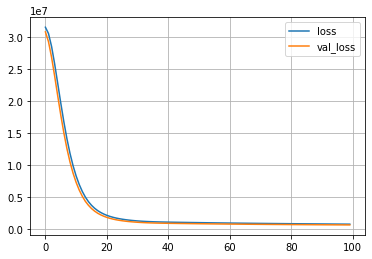

In [28]:
#baseline
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_squared_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=100,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback],
  verbose=0
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)

### Attempt Optimization

Looks like lots of loss! What to do?

Things to try:
<ol>
<li> Depth.
<li> Width. 
<li> Activations. 
</ol>

In [29]:
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(X_tr_ex))

mod_ex = keras.Sequential()
mod_ex.add(normalizer)
mod_ex.add(InputLayer(input_shape=(start_width,)))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(start_width, activation='relu'))
mod_ex.add(Dense(1))

mod_ex.compile(optimizer='adam', loss="mean_squared_error")

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=20, restore_best_weights=True) 

hist_ex = mod_ex.fit(
  X_tr_ex,
  y_tr_ex,
  epochs=1000,
  batch_size=64,
  validation_split=0.2,
  callbacks=[callback],
  verbose=0
)
print(mod_ex.evaluate(X_te_ex, y_te_ex))
plot_loss(hist_ex)